In [1]:
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# ### Load data (one file)
# file = "../data/onetrack_multicluster/pion_files/001.npy"
# event_data = np.load(file, allow_pickle=True).item()
# df = pd.DataFrame(event_data)

In [3]:
### Load data (multiple files)
n_files = 100
files = glob.glob("../data/onetrack_multicluster/pion_files/*.npy")
df = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files[:n_files])])
print("Dataframe has {:,} events.".format(df.shape[0]))

100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


Dataframe has 1,027,650 events.


In [4]:
df.keys()

Index(['index', 'cluster_cell_E', 'cluster_cell_ID', 'trackPt', 'trackD0',
       'trackZ0', 'trackEta_EMB2', 'trackPhi_EMB2', 'trackEta_EME2',
       'trackPhi_EME2', 'trackEta', 'trackPhi', 'nCluster', 'nTrack',
       'truthPartE', 'truthPartPt', 'cluster_ENG_CALIB_TOT', 'cluster_E',
       'cluster_Eta', 'cluster_Phi', 'cluster_EM_PROBABILITY',
       'cluster_E_LCCalib', 'cluster_HAD_WEIGHT', 'deltaR', 'dR_pass',
       'event_number'],
      dtype='object')

In [5]:
### Start the dataframe of inputs 
# df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list())[0]) # just take the leading cluster E 
df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list(), columns=["cluster_e_"+str(x) for x in np.arange(35)]))

### Add track pT & truth particle E 
track_pt = np.array(df.trackPt.explode())
truth_particle_e = np.array(df.truthPartE.explode())
track_eta = np.array(df.trackEta.explode())
track_phi = np.array(df.trackPhi.explode())
track_z0 = np.array(df.trackZ0.explode())

df2["track_pt"] = track_pt
df2["track_eta"] = track_eta
df2["track_phi"] = track_phi
df2["track_z0"] = track_z0
df2["truth_particle_e"] = truth_particle_e

### Drop infs/NaNs 
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df2 = df2.fillna(0)

### Cluster_E > 0.5
df2 = df2[df2.cluster_e_0 > 0.5]

### Lose outliers in track pT 
df2 = df2[df2.track_pt < 5000]

### Cast as float
df2 = df2.astype('float32')

### Add the log of all energy variables
for var in df2.keys():
    if var in ["track_eta", "track_phi", "track_z0"]:
        continue
    else:
        df2['log10_'+var] = np.log10(df2[var])
    
### Do this again? 
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df2 = df2.fillna(0)

/clusterfs/ml4hep/mpettee/miniconda3/envs/nbdev/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
df2.keys()

Index(['cluster_e_0', 'cluster_e_1', 'cluster_e_2', 'cluster_e_3',
       'cluster_e_4', 'cluster_e_5', 'cluster_e_6', 'cluster_e_7',
       'cluster_e_8', 'cluster_e_9', 'cluster_e_10', 'cluster_e_11',
       'cluster_e_12', 'cluster_e_13', 'cluster_e_14', 'cluster_e_15',
       'cluster_e_16', 'cluster_e_17', 'cluster_e_18', 'cluster_e_19',
       'cluster_e_20', 'cluster_e_21', 'cluster_e_22', 'cluster_e_23',
       'cluster_e_24', 'cluster_e_25', 'cluster_e_26', 'cluster_e_27',
       'cluster_e_28', 'cluster_e_29', 'cluster_e_30', 'cluster_e_31',
       'cluster_e_32', 'cluster_e_33', 'cluster_e_34', 'track_pt', 'track_eta',
       'track_phi', 'track_z0', 'truth_particle_e', 'log10_cluster_e_0',
       'log10_cluster_e_1', 'log10_cluster_e_2', 'log10_cluster_e_3',
       'log10_cluster_e_4', 'log10_cluster_e_5', 'log10_cluster_e_6',
       'log10_cluster_e_7', 'log10_cluster_e_8', 'log10_cluster_e_9',
       'log10_cluster_e_10', 'log10_cluster_e_11', 'log10_cluster_e_12',
      

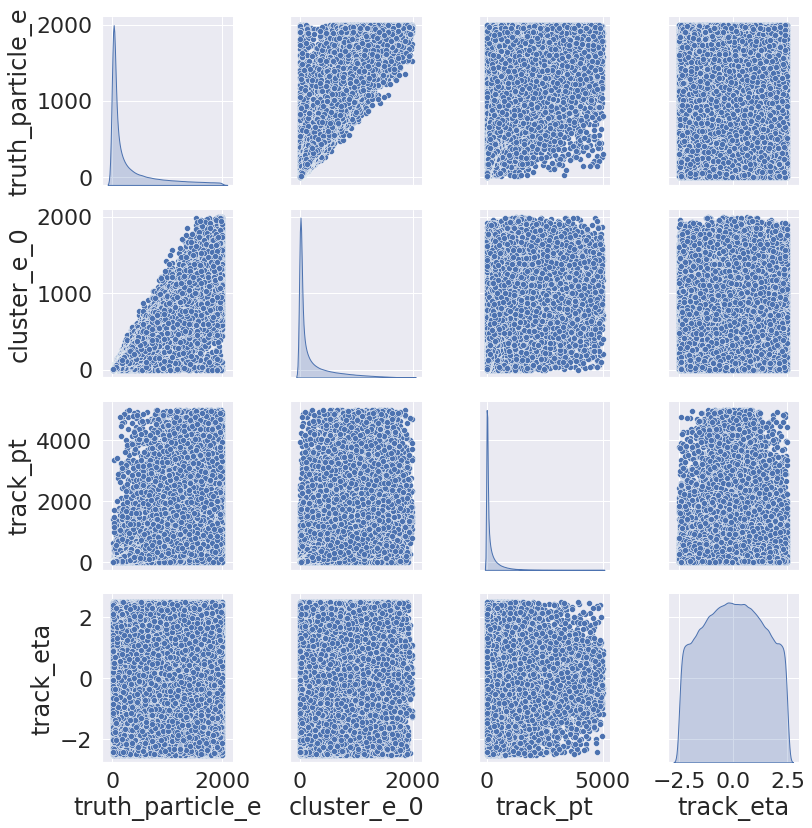

In [7]:
### Inspect variables 
sns.set(font_scale = 2)
corr_vars = ['truth_particle_e', 'cluster_e_0', 'track_pt', 'track_eta']
g = sns.pairplot(df2[corr_vars], diag_kind='kde')
g.fig.set_figheight(12)
g.fig.set_figwidth(12)

In [8]:
### Test/train split 
train = df2.sample(frac=0.8, random_state=0)
test = df2.drop(train.index)

train_vars = [
    'log10_cluster_e_0', 
    'log10_track_pt',
    'track_eta'
             ]

### All clusters + track eta/phi/z0
# train_vars = [var for var in df2.keys() if var.startswith('log10') and var != 'log10_truth_particle_e']
# train_vars += ['track_eta', 'track_phi', 'track_z0']

train_x = train[train_vars].values
train_y = train['log10_truth_particle_e'].values
test_x = test[train_vars].values
test_y = test['log10_truth_particle_e'].values

In [10]:
### Normalize the inputs 
sc = StandardScaler()
train_x = sc.fit_transform(train_x)
test_x = sc.transform(test_x)

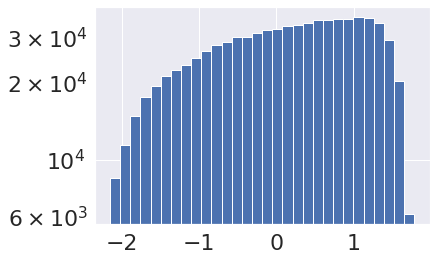

In [11]:
plt.hist(train_x[:,0], bins=30);
plt.yscale('log');

In [12]:
def regression_model():
    model = Sequential()
    model.add(Dense(50, input_dim=train_x.shape[1], activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [13]:
model = regression_model()
model.summary()

2022-05-02 16:54:36.206065: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 5,351
Trainable params: 5,351
Non-trainable params: 0
_________________________________________________________________


2022-05-02 16:54:37.907483: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 41271 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-05-02 16:54:37.908359: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43662 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6
2022-05-02 16:54:37.909035: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 43662 MB memory:  -> device: 2, name: NVIDIA A40, pci bus id: 0000:81:00.0, compute capability: 8.6
2022-05-02 16:54:37.909660: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 43662 MB memory:  -> device: 3, name: NVIDIA A40, pci bus id: 0000:c1:00.0, compute capability: 8.6


In [14]:
%%time
history = model.fit(
    train_x,
    train_y,
    validation_split=0.2,
    verbose=1, epochs=20)

Epoch 1/20


2022-05-02 16:54:38.484601: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


  111/20082 [..............................] - ETA: 27s - loss: 0.7576

2022-05-02 16:54:39.625247: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


20082/20082 [==============================] - 45s 2ms/step - loss: 0.0103 - val_loss: 0.0051
Epoch 2/20
20082/20082 [==============================] - 45s 2ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 3/20
20082/20082 [==============================] - 45s 2ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 4/20
20082/20082 [==============================] - 45s 2ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 5/20
20082/20082 [==============================] - 45s 2ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 6/20
20082/20082 [==============================] - 45s 2ms/step - loss: 0.0050 - val_loss: 0.0053
Epoch 7/20
20082/20082 [==============================] - 45s 2ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 8/20
20082/20082 [==============================] - 45s 2ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 9/20
20082/20082 [==============================] - 45s 2ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 10/20
20082/20082 [==============================] - 44s 2ms

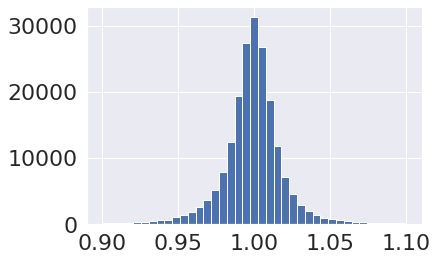

In [18]:
### Evaluate performance on test set 
test['nn_score'] = model.predict(test_x)
plt.hist(test.nn_score/test.log10_truth_particle_e, bins=np.linspace(0.9,1.1,40));

/tmp/ipykernel_29949/2215468053.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.hist2d(x, y, bins=[xbin, ybin], norm=LogNorm(),zorder = -1, cmap=c_map);


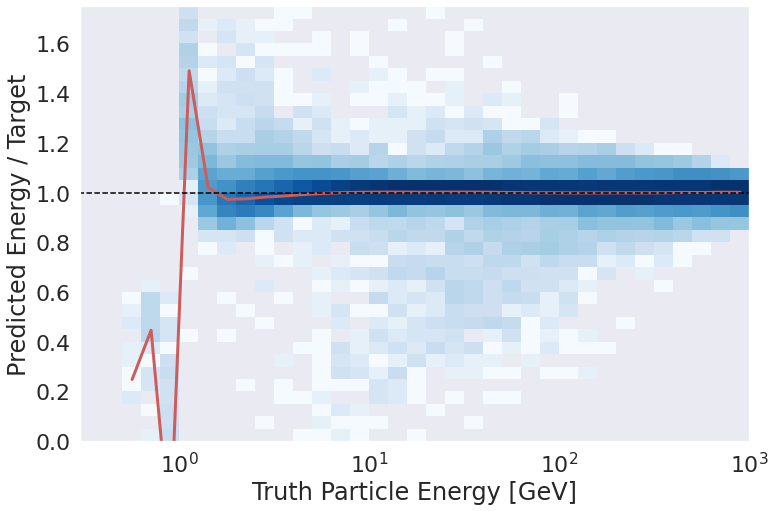

In [16]:
### Response median plot 
import scipy.stats as stats
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm

x = test.truth_particle_e
y = test.nn_score/test.log10_truth_particle_e

xbin = [10**exp for exp in np.arange(-1., 3.1, 0.1)]
ybin = np.arange(0., 3.1, 0.05)
xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
profileXMed = stats.binned_statistic(
    x, y, bins=xbin, statistic='median').statistic

c_map = ListedColormap(sns.color_palette("Blues", n_colors=100).as_hex())
fig = plt.figure(figsize=(12,8))
fig.patch.set_facecolor('white')
plt.hist2d(x, y, bins=[xbin, ybin], norm=LogNorm(),zorder = -1, cmap=c_map);
plt.plot(np.array(xcenter), np.array(profileXMed), color='indianred', linewidth=3)
plt.plot([0.1, 1000], [1, 1], linestyle='--', color='black');
plt.xscale('log')
plt.ylim(0, 1.75)
plt.xlim(0.3, )
plt.xlabel('Truth Particle Energy [GeV]')
plt.ylabel('Predicted Energy / Target');
np.savez('pub_note_results/response_median_simple.npz', response_median=profileXMed, xcenter=xcenter)

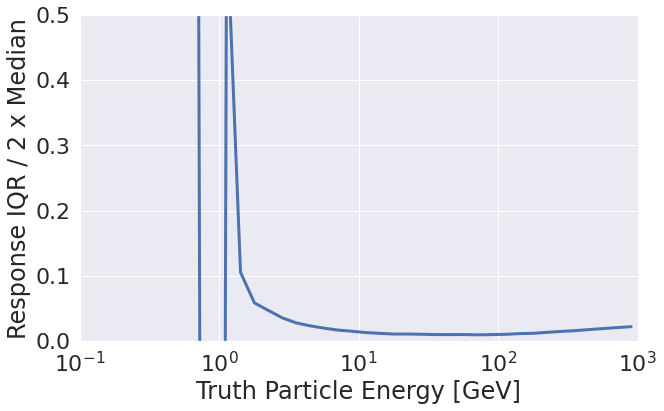

In [17]:
### IQR plot 

def iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q84, q16 = np.percentile(x, [84, 16])
    iqr = q84 - q16
    med = np.median(x)
    return iqr / (2*med)

resolution = stats.binned_statistic(x, y, bins=xbin,statistic=iqrOverMed).statistic

fig = plt.figure(figsize=(10,6))
fig.patch.set_facecolor('white')
plt.plot(xcenter, resolution, linewidth=3)
plt.xscale('log')
plt.xlim(0.1, 1000)
plt.ylim(0,0.5)
plt.xlabel('Truth Particle Energy [GeV]')
plt.ylabel('Response IQR / 2 x Median');

np.savez('pub_note_results/iqr_simple.npz', iqr=resolution, xcenter=xcenter)